# Ensemble-based models to predict age

**Can we predict age from blood gene expression data?**

- Random forest
- XGBoost

author: @emilyekstrum
<br> 12/11/25

In [32]:
#load in modules
import numpy as np
import pandas as pd
import gzip
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# random seed
np.random.seed(42)

In [33]:
# load latent spaces
latent_spaces = np.load('gtex_latent_spaces.npz')
pca_result_2d = latent_spaces['pca_2d']
pca_result_85 = latent_spaces['pca_hd']
umap_result_2d = latent_spaces['umap_from_2d']
umap_result_hd = latent_spaces['umap_from_hd']

print(f"Latent space shapes:")
print(f"PCA 2D: {pca_result_2d.shape}")
print(f"PCA high-D: {pca_result_85.shape}")
print(f"UMAP from 2D: {umap_result_2d.shape}")
print(f"UMAP from high-D: {umap_result_hd.shape}")

Latent space shapes:
PCA 2D: (12289, 2)
PCA high-D: (12289, 83)
UMAP from 2D: (12289, 2)
UMAP from high-D: (12289, 2)


In [34]:
# open merged dataframe to get age and tissue labels
with gzip.open('GTEx_merged_processed_data.csv.gz', 'rt') as f:
    merged_df = pd.read_csv(f)

# extract age and tissue labels
age_labels = merged_df['AGE'].values
tissue_labels = merged_df['SMTS'].values
print(f"Number of samples: {len(age_labels)}")
print(f"Age range: {np.nanmin(age_labels)} - {np.nanmax(age_labels)}")

Number of samples: 12289
Age range: 25 - 75


/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_78330/1878618888.py:3: DtypeWarning: Columns (5008) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(f)


In [35]:
# select only blood samples from latent spaces and labels
blood_mask = merged_df['SMTS'] == 'Blood'
blood_indices = merged_df[blood_mask].index

# subset latent spaces and age labels for blood samples
pca_2d_blood = pca_result_2d[blood_indices]
pca_hd_blood = pca_result_85[blood_indices]
umap_2d_blood = umap_result_2d[blood_indices]
umap_hd_blood = umap_result_hd[blood_indices]
age_blood = age_labels[blood_indices]

# remove NaN ages
valid_age_mask = ~np.isnan(age_blood)
pca_2d_blood = pca_2d_blood[valid_age_mask]
pca_hd_blood = pca_hd_blood[valid_age_mask]
umap_2d_blood = umap_2d_blood[valid_age_mask]
umap_hd_blood = umap_hd_blood[valid_age_mask]
age_blood = age_blood[valid_age_mask]

### Hyperparameter sweep 

Tests different parameters for: 
- Random forest: n_estimators, max_depth
- XGBoost: booster, max_depth, learning_rate

In [40]:
#  hyperparameter sweep function
def hyperparameter_sweep(X_data, y_data, space_name, n_jobs=-1):
    """
    hyperparameter sweeping for ensemble methods
    """
    print(f"\nHyperparameter sweep for {space_name}")
    
    # split data (remove stratify for continuous targets)
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42
    )
    
    # split training data for validation
    X_train_inner, X_val, y_train_inner, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    results = {}
    
    # 1. Random forest hyperparameter sweep
    print("\n1. Random forest hyperparameter sweep")
    rf_params = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [1, 2, 3, 4, 5],
    }
    
    best_rf_score = -float('inf') 
    best_rf_params = None
    rf_results = []
    
    total_combinations = len(list(product(*rf_params.values())))
    current_combo = 0
    
    for n_est in rf_params['n_estimators']:
        for max_depth in rf_params['max_depth']:
                current_combo += 1
                try:
                    rf_model = RandomForestRegressor(
                        n_estimators=n_est,
                        max_depth=max_depth,
                        random_state=42
                    )
                    
                    rf_model.fit(X_train_inner, y_train_inner)
                    val_score = rf_model.score(X_val, y_val)
                    
                    rf_results.append({
                        'n_estimators': n_est,
                        'max_depth': max_depth,
                        'val_score': val_score
                    })
                    
                    if val_score > best_rf_score:
                        best_rf_score = val_score
                        best_rf_params = {'n_estimators': n_est, 'max_depth': max_depth}
                    
                    if current_combo % 10 == 0:
                        print(f"  Progress: {current_combo}/{total_combinations} - Best so far: {best_rf_score:.4f}")
                        
                except Exception as e:
                    print(f"  Error with params {n_est}, {max_depth}: {e}")
    
    print(f"  Best Random Forest params: {best_rf_params} (Score: {best_rf_score:.4f})")
    
    # 2. XGBoost hyperparameter sweep
    print("\n2. XGBoost hyperparameter sweep")
    xgboost_params = {
        'booster': ['gbtree', 'dart'],
        'max_depth': [1, 2, 3, 4],
        'learning_rate': [0.01, 0.1, 0.2, 0.3]
    }
    
    best_boost_score = -float('inf')
    best_boost_params = None
    boost_results = []
    
    current_combo = 0
    total_combinations = len(list(product(*xgboost_params.values())))
    
    for booster in xgboost_params['booster']:
        for max_depth in xgboost_params['max_depth']:
            for learning_rate in xgboost_params['learning_rate']:
                current_combo += 1
                try:
                    boost_model = xgb.XGBRegressor(
                        booster=booster,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        random_state=42
                    )
                    
                    boost_model.fit(X_train_inner, y_train_inner)
                    val_score = boost_model.score(X_val, y_val)
                    
                    boost_results.append({
                        'booster': booster,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'val_score': val_score
                    })
                    
                    if val_score > best_boost_score:
                        best_boost_score = val_score
                        best_boost_params = {
                            'booster': booster,
                            'max_depth': max_depth,
                            'learning_rate': learning_rate
                        }
                    
                    if current_combo % 10 == 0:
                        print(f"  Progress: {current_combo}/{total_combinations} - Best so far: {best_boost_score:.4f}")
                        
                except Exception as e:
                    print(f"  Error with params: {e}")
    
    print(f"  Best XGBoost params: {best_boost_params} (Score: {best_boost_score:.4f})")
    
    # train best models on full training set and evaluate on test set
    print("\n3. Evaluation on test set")
    final_results = {}
    
    # Best random forest
    if best_rf_params:
        final_rf = RandomForestRegressor(**best_rf_params, random_state=42)
        final_rf.fit(X_train, y_train)
        rf_test_score = final_rf.score(X_test, y_test)
        final_results['Random Forest'] = {
            'model': final_rf,
            'params': best_rf_params,
            'test_score': rf_test_score,
            'predictions': final_rf.predict(X_test)
        }
        print(f"  Random forest test R^2 score: {rf_test_score:.4f}")
    
    # Best XGBoost
    if best_boost_params:
        final_boost = xgb.XGBRegressor(
            **best_boost_params,
            random_state=42
        )
        final_boost.fit(X_train, y_train)
        boost_test_score = final_boost.score(X_test, y_test)
        final_results['XGBoost'] = {
            'model': final_boost,
            'params': best_boost_params,
            'test_score': boost_test_score,
            'predictions': final_boost.predict(X_test)
        }
        print(f"  XGBoost test R^2 score: {boost_test_score:.4f}")
    
    # Store results
    results[space_name] = {
        'final_models': final_results,
        'y_test': y_test,
        'rf_sweep': rf_results,
        'boost_sweep': boost_results
    }
    
    # Add best overall only if we have results
    if final_results:
        results[space_name]['best_overall'] = max(final_results.items(), key=lambda x: x[1]['test_score'])
    else:
        results[space_name]['best_overall'] = None
        print("  Warning: No successful models found!")
    
    return results[space_name]

In [41]:
# perform hyperparameter sweeping on blood samples for age prediction

# create dictionary of latent spaces for blood samples
blood_latent_spaces_dict = {
    'PCA_2D': pca_2d_blood,
    'PCA_HighD': pca_hd_blood,
    'UMAP_from_2D': umap_2d_blood,
    'UMAP_from_HighD': umap_hd_blood
}

print("Blood latent spaces for age prediction:")
for name, data in blood_latent_spaces_dict.items():
    print(f"  {name}: {data.shape}")

# run hyperparameter sweep for each latent space
sweep_results = {}

for space_name, X_data in blood_latent_spaces_dict.items():
    sweep_results[space_name] = hyperparameter_sweep(X_data, age_blood, space_name)

Blood latent spaces for age prediction:
  PCA_2D: (578, 2)
  PCA_HighD: (578, 83)
  UMAP_from_2D: (578, 2)
  UMAP_from_HighD: (578, 2)

Hyperparameter sweep for PCA_2D

1. Random forest hyperparameter sweep
  Progress: 10/20 - Best so far: 0.1113
  Progress: 10/20 - Best so far: 0.1113
  Progress: 20/20 - Best so far: 0.1139
  Best Random Forest params: {'n_estimators': 300, 'max_depth': 3} (Score: 0.1139)

2. XGBoost hyperparameter sweep
  Progress: 20/20 - Best so far: 0.1139
  Best Random Forest params: {'n_estimators': 300, 'max_depth': 3} (Score: 0.1139)

2. XGBoost hyperparameter sweep
  Progress: 10/32 - Best so far: 0.0891
  Progress: 10/32 - Best so far: 0.0891
  Progress: 20/32 - Best so far: 0.0891
  Progress: 20/32 - Best so far: 0.0891
  Progress: 30/32 - Best so far: 0.0891
  Progress: 30/32 - Best so far: 0.0891
  Best XGBoost params: {'booster': 'gbtree', 'max_depth': 2, 'learning_rate': 0.01} (Score: 0.0891)

3. Evaluation on test set
  Random forest test R^2 score: -0

In [42]:
# results analysis
print("\nResults")

# compile all results
all_results = []
for space_name, space_results in sweep_results.items():
    for model_name, model_results in space_results['final_models'].items():
        all_results.append({
            'latent_space': space_name,
            'model': model_name,
            'test_accuracy': model_results['test_score'],
            'parameters': model_results['params']
        })

# create results dataframe
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('test_accuracy', ascending=False)

print("\nTop 10 Models:")
print(results_df.head(10).to_string(index=False))

# best model overall
best_config = results_df.iloc[0]
print(f"\nBest Model:")
print(f"Latent Space: {best_config['latent_space']}")
print(f"Model: {best_config['model']}")
print(f"Test Accuracy: {best_config['test_accuracy']:.4f}")
print(f"Parameters: {best_config['parameters']}")


Results

Top 10 Models:
   latent_space         model  test_accuracy                                                   parameters
      PCA_HighD Random Forest       0.076520                         {'n_estimators': 50, 'max_depth': 1}
UMAP_from_HighD Random Forest       0.075411                         {'n_estimators': 50, 'max_depth': 2}
UMAP_from_HighD       XGBoost       0.074957 {'booster': 'gbtree', 'max_depth': 2, 'learning_rate': 0.01}
      PCA_HighD       XGBoost       0.062352 {'booster': 'gbtree', 'max_depth': 1, 'learning_rate': 0.01}
         PCA_2D       XGBoost       0.009363 {'booster': 'gbtree', 'max_depth': 2, 'learning_rate': 0.01}
   UMAP_from_2D       XGBoost       0.005512 {'booster': 'gbtree', 'max_depth': 3, 'learning_rate': 0.01}
         PCA_2D Random Forest      -0.016771                        {'n_estimators': 300, 'max_depth': 3}
   UMAP_from_2D Random Forest      -0.038215                        {'n_estimators': 100, 'max_depth': 2}

Best Model:
Latent S

### Visualize resutls

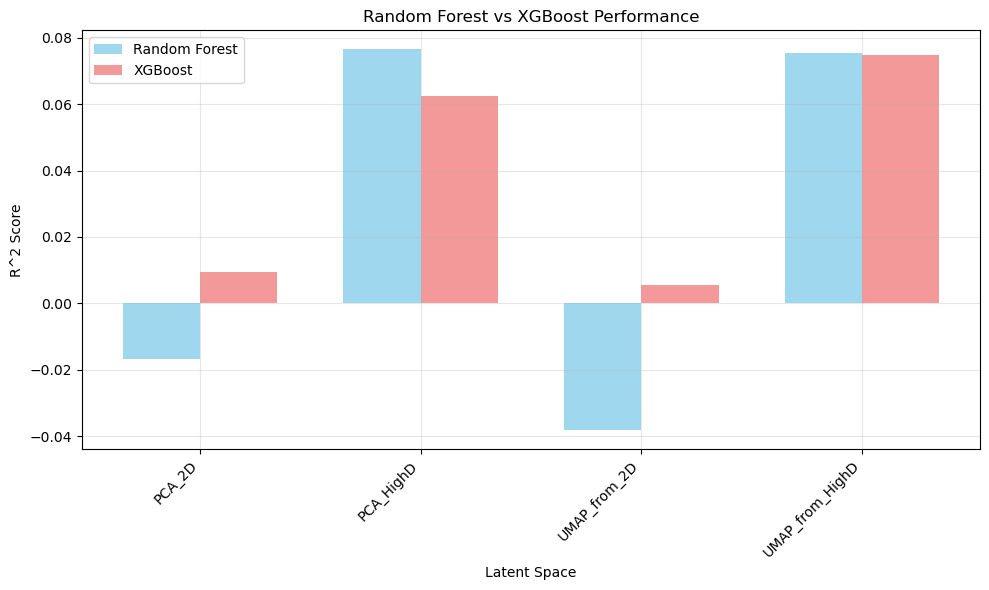

In [44]:
# plot performance comparison across latent spaces
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Prepare data for plotting
spaces = []
rf_scores = []
xgb_scores = []
best_scores = []

for space_name, results in sweep_results.items():
    spaces.append(space_name)
    
    # get RF score
    if 'Random Forest' in results['final_models']:
        rf_scores.append(results['final_models']['Random Forest']['test_score'])
    else:
        rf_scores.append(0)
    
    # get XGBoost score
    if 'XGBoost' in results['final_models']:
        xgb_scores.append(results['final_models']['XGBoost']['test_score'])
    else:
        xgb_scores.append(0)
    
    # get best overall score
    if results['best_overall']:
        best_scores.append(results['best_overall'][1]['test_score'])
    else:
        best_scores.append(0)

# bar plot comparing RF vs XGBoost
x_pos = np.arange(len(spaces))
width = 0.35
ax.bar(x_pos - width / 2, rf_scores, width, label='Random Forest', alpha=0.8, color='skyblue')
ax.bar(x_pos + width / 2, xgb_scores, width, label='XGBoost', alpha=0.8, color='lightcoral')
ax.set_xlabel('Latent Space')
ax.set_ylabel('R^2 Score')
ax.set_title('Random Forest vs XGBoost Performance')
ax.set_xticks(x_pos)
ax.set_xticklabels(spaces, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()